_BloomTech Data Science, Unit 2_

---

👇 **Do not change the code in this cell.** If you're working in Google Colab, you can run this cell to install `category_encoders`.

In [ ]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders

 
# Sprint Challenge: Predict Steph Curry's Shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts from October 2009 through June 2019 (regular season and playoffs). The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

You'll create a model to predict whether Curry will make a shot based on his past perfomance.

# Directions

This notebook contains 10 tasks, which cover the material we've learned in this sprint. Here's a summary:

- **Task 1:** Importing data.
- **Task 2:** Feature engineering.
- **Task 3:** Splitting data into a feature matrix and target vector.
- **Task 4:** Splitting data into training, validation, and test sets.
- **Task 5:** Establishing baseline accuracy.
- **Task 6:** Building a model with a transformer and a tree-based predictor.
- **Task 7:** Calculating training and validation accuracy.
- **Task 8 (`stretch goal`):** Tuning model hyperparameters.
- **Task 9:** Calculating precision and recall from a confusion matrix.
- **Task 10 (`stretch goal`):** Plotting a confusion matrix.

For each task you should do the following:

- Read the task instructions.
- Write your code in the cell below the task. Delete the `raise 
NotImplementedError` before your start.
- Run the testing cell below the task. If you get an error, read the error message and re-evaluate your code.

**You should limit your code to the following libraries:**

- `category_encoders`
- `numpy`
- `matplotlib`
- `pandas`
- `sklearn`



# I. Wrangle Data

**Task 1:** Change the code below to import your dataset. Be sure to examine the columns carefully and determine if one of them should be set at the index. 

In [39]:
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import plot_confusion_matrix, classification_report, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, validation_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
import numpy as np
import pandas as pd

In [10]:
'''T1. Import DataFrame `df`'''

import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url, parse_dates= ['game_date'],
                 index_col= ['game_date'])
# YOUR CODE HERE
df.tail()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,htm,vtm,season_type,scoremargin_before_shot
game_date,,,,,,,,,,,,,,,,,,,
2019-06-05,41800403,570,Stephen Curry,4,8,1,Pullup Jump shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,12,3,120,1,GSW,TOR,Playoffs,-13.0
2019-06-05,41800403,573,Stephen Curry,4,7,16,Floating Jump shot,2PT Field Goal,Mid-Range,Right Side(R),8-16 ft.,11,114,-5,0,GSW,TOR,Playoffs,-14.0
2019-06-05,41800403,602,Stephen Curry,4,5,27,Step Back Jump shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,26,-217,149,0,GSW,TOR,Playoffs,-17.0
2019-06-05,41800403,608,Stephen Curry,4,4,50,Driving Floating Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,7,59,49,0,GSW,TOR,Playoffs,-16.0
2019-06-05,41800403,658,Stephen Curry,4,2,47,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,24,-226,104,0,GSW,TOR,Playoffs,-12.0


In [4]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

**Task 1 Testing**

In [5]:
'''T1 Testing'''

assert isinstance(df, pd.DataFrame), 'Have you created a DataFrame named `df`?'
assert len(df) == 13958, 'Is `df` the correct length?'


**Task 2a:** Engineer at least 1 new feature. You can use something from the list below or your own idea.

- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?

**Task 2b (`stretch goal — optional`):** Create a total of 3 new features, using your own ideas or the list above. Make sure you're not just duplicating features that are already in the feature matrix.

In [15]:
"""T2. Create new feature"""

# Homecourt Advantage can be determined by setting a boolean equation to a new column
df['homecourt_advantage'] = df['htm'] == 'GSW'

# Opponent can be made by adding together both vtm and htm with GSW replaced with a blank value.
df['opponent'] = (df['vtm'].replace('GSW', '') + df['htm'].replace('GSW', ''))

# Multiply minutes remaining by 60, add the seconds remaining
df['seconds_remaning_in_the_period'] = ((df['minutes_remaining'] * 60 )+ df['seconds_remaining'])

# 4 - the period you are in times minutes in period times seconds in minute
df['seconds_remaining_in_the_game'] = (df['minutes_remaining'] * 60) + df['seconds_remaining'] + ((4-df['period']) * 12 * 60)

df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,...,loc_y,shot_made_flag,htm,vtm,season_type,scoremargin_before_shot,homecourt_advantage,seconds_remaning_in_the_period,opponent,seconds_remaining_in_the_game
game_date,,,,,,,,,,,,,,,,,,,,,
2009-10-28,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),...,249,0,GSW,HOU,Regular Season,2.0,True,685,HOU,2845
2009-10-28,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),...,145,1,GSW,HOU,Regular Season,0.0,True,571,HOU,2731
2009-10-28,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),...,129,0,GSW,HOU,Regular Season,-4.0,True,362,HOU,2522
2009-10-28,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),...,82,0,GSW,HOU,Regular Season,-4.0,True,589,HOU,2029
2009-10-28,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),...,148,0,GSW,HOU,Regular Season,0.0,True,139,HOU,1579


**Task 2 Test**

In [16]:
'''T2 Testing'''

assert df.shape[1] >= 20, '`df` does not appear to have new features.'


# II. Split Data

**Task 3:** Divide the DataFrame `df` into the feature matrix `X` and the target vector `y`. Your target is `'shot_made_flag'`.

In [19]:
'''T3. Create `X` and `y`.'''
target = 'shot_made_flag'

X = df.drop(columns= target)
y = df[target]

**Task 3 Test**

In [20]:
'''T3 Tests'''

assert y.shape == (13958,), '`y` either has the wrong number of rows, or is two-dimentional.'
assert len(X) == 13958, '`X` has the wrong number of rows.'
assert X.shape[1] > 1, '`X` has the wrong number of columns'
assert 'shot_made_flag' not in X.columns, 'Target is still part of feature matrix.' 

**Task 4:** Divide your dataset into training, validation, and test sets. 

- Your training set (`X_train`, `y_train`) should contain games from the 2009-10 season through the end of the 2016-17 season.
- Your validation set (`X_val`, `y_val`) should contain games from the 2017-18 season.
- Your test set (`X_test`, `y_test`) should contain games from the 2018-2019 season.
- **Tip:** The NBA season begins in October and ends in June.

In [30]:
'''T4. Create training and val'''
#Create first cutoff date
cutoff1 = '2018-07-01'

#Create first data mask
mask1 = X.index < cutoff1
mask3 = X.index > cutoff1

#Create testing dataset
X_train1, y_train1 = X.loc[mask1], y.loc[mask1]
X_test, y_test = X.loc[~mask1], y.loc[~mask1]

#Create secondary cutoff
cutoff2 = '2017-07-01'

# Create secondary data mask
mask2 = X_train1.index < cutoff2

#Create training and validation data sets
X_train, y_train = X_train1.loc[mask2], y_train1.loc[mask2]
X_val, y_val = X_train1.loc[~mask2], y_train1.loc[~mask2]

**Test 4**

In [36]:
'''T4 Tests'''
assert len(X_train) == len(y_train) == 11081
assert len(X_val) == len(y_val) == 1168
assert len(X_test) == len(y_test) == 1709


# III. Establish Baseline

**Task 5:** Establish the baseline accuracy score for this classification problem using your training set. Save the score to the variable `baseline_acc`.

In [37]:
'''T5. Calculate baseline accuracy `baseline_acc`.'''

# YOUR CODE HERE
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline Accuracy:', baseline_acc)

Baseline Accuracy: 0.5272087356736757


**Task 5 Testing**

In [38]:
'''T5 Testing'''

assert isinstance(baseline_acc, float)
assert 0.0 <= baseline_acc <= 1.0


# IV. Build Model

**Task 6:** Build a model that includes (1) a transformer for categorical features and (2) a tree-based predictor. You should combine these two components (and any other pieces you think are necessary) in a pipeline named `model`. Be sure to fit your model to your training data.

In [40]:
'''T6. Build a pipeline `model` with encoder and tree-based predictor.'''

# YOUR CODE HERE
model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy = 'median'),
    RandomForestClassifier(random_state=42,
                           n_estimators= 50,
                           max_depth= 25,
                           n_jobs= -1)
)
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['player_name', 'action_type', 'shot_type',
                                      'shot_zone_basic', 'shot_zone_area',
                                      'shot_zone_range', 'htm', 'vtm',
                                      'season_type', 'opponent'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'player_name',
                                          'data_type': dtype('O'),
                                          'mapping': Stephen Curry    1
NaN             -2
dtyp...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=25, max_features='auto',
                                        max_leaf_nodes=None, ma

**Task 6 Testing**

In [41]:
'''T6 Testing'''

from sklearn.pipeline import Pipeline
assert isinstance(model, Pipeline), '`model` should be type `Pipeline`.'

# Does `model` Pipeline have multiple components?
assert len(model.named_steps.keys()) > 1, '`model` should have more than one component.'

# Has `model` been trained?
assert hasattr(model, 'classes_'), 'Have you trained `model`?'


# V. Check Metrics

**Task 7:** Check the training and validation accuracy of your model, and assign the scores to `train_acc` and `val_acc` respectively.

In [42]:
'''T7. Calculate train and test accuracy.'''

# YOUR CODE HERE
train_acc = model.score(X_train, y_train)

val_acc = model.score(X_val, y_val)
print('Training Accuracy Score:', train_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.9995487771861745
Validation Accuracy Score: 0.5856164383561644


**Task 7 Test**

In [43]:
'''T7 Testing'''

# Is `training_acc` a float between 0.0 and 1.0?
assert isinstance(train_acc, float)
assert 0.0 <= train_acc <= 1.0

# Is `validation_acc` a float between 0.0 and 1.0?
assert isinstance(val_acc, float)
assert 0.0 <= val_acc <= 1.0


# VI. Tune Model

**Task 8 (`stretch goal — optional`):** Using your training and validation sets as a guide, tune the hyperparameters of your model to see if you can improve its accuracy. You can perform your tuning "by hand" or using [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

- Important hyperparameters for all tree-based models: `max_depth`.
- Important hyperparameters for random forest models: `n_estimators`, `max_samples`. 
- Important hyperparametes for gradient boosting tree models: `n_estimators`, `learning_rate`.
- **TIP:** If you use `RandomizedSearchCV`, set `n_iter` to `3`. Any larger and the auto-grader will stop working.
- **TIP:** Since you already created a validation set above, there is no need to do k-fold cross-validation here. Set `cv` to `None`.

Once you're satisfied with your model's performance on the validation set (if you can get above `0.6`, you're doing good), calculate its accuracy with your test set. Assign the result to `test_acc`.

In [51]:
'''T8. Tune model.'''

# YOUR CODE HERE
# create pipeline outside of original model for testing
clf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42)
)

#Create a grid for the search. Specify ranges and strategy options
param_grid = {
    'simpleimputer__strategy':['mean','median'],
    'randomforestclassifier__max_depth': range(5,35,5),
    'randomforestclassifier__n_estimators': range(25,125,25)
}

#Create the search model
model = RandomizedSearchCV(
    clf,
    param_distributions = param_grid,
    n_iter = 3,
    cv = None,
    n_jobs = -1,
    verbose = 1
)

#Fit the model
model.fit(X_train,y_train)

#Explore best parameters for hypertuning
model.best_params_

#Calc and print test score accuracy
test_acc = model.score(X_test, y_test) 
print('Testing Accuracy Score:', test_acc)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    3.8s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    4.3s finished


Testing Accuracy Score: 0.6284376828554711


**Task 8 Testing**

In [45]:
'''T8 Testing'''
assert isinstance(test_acc, float)
assert 0.0 <= test_acc <= 1.0

# VII. Communication

**Task 9:** Below is a confusion matrix for the model that your instructor made for this challenge (based on the **test data**). Calculate the precision and recall of this model, naming them `instructor_precision` and `instructor_recall`, respectively.

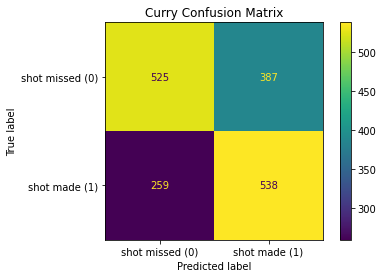

In [46]:
'''T9. Calculate precision and recall'''
instructor_precision = 525 / (525 + 387)

instructor_recall = 525 / (525 + 259)
print('Instuctor model precision', instructor_precision)
print('Instuctor model recall', instructor_recall)

Instuctor model precision 0.5756578947368421
Instuctor model recall 0.6696428571428571


**Task 9 Testing**

In [47]:
'''T9 Testing'''
assert isinstance(instructor_precision, float)
assert isinstance(instructor_recall, float)
assert 0 <= instructor_precision <= 1
assert 0 <= instructor_recall <= 1

**Task 10 (`stretch goal — optional`):** Plot confusion matrix for your model using your **test data**. Does your model have higher recall or higher precision? How does your model's metrics compare to the metrics you calculated above?

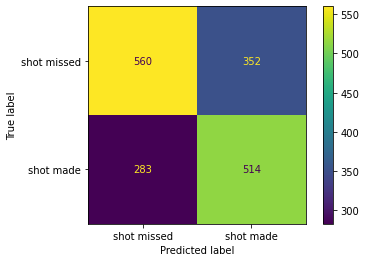

In [52]:
'''T10. Plot ROC curve.'''
plot_confusion_matrix(model, X_test, y_test, values_format= '.0f',
                      display_labels=['shot missed', 'shot made']);

In [54]:
student_precision = 560 / (560 + 352)

student_recall = 560 / (560 +283)

print('Instuctor model precision vs Student model precision',
      instructor_precision, 'vs', student_precision)
print('Instuctor model recall vs Student model recall',
      instructor_recall, 'vs', student_recall)

Instuctor model precision vs Student model precision 0.5756578947368421 vs 0.6140350877192983
Instuctor model recall vs Student model recall 0.6696428571428571 vs 0.66429418742586
